## 4.4 数据增强方法

在训练模型时，我们采用的图像数据越多，建立有效、准确的模型的概率就越大。如果没有理想的海量数据，我们应该怎么办呢？此时我们可以采取数据增强方法来增加数据集的大小以及多样性。数据增强（Data Augmentation）是指对图像进行随机的旋转、裁剪、随机改变图像的亮度和对比度以及对数据进行标准化(数据的均值为0，方差为1)等一系列操作。
如图4-6所示，我们可以通过不同的数据增强方法制作出6张标签相同（都是狗）的图，从而增加我们学习的样本。
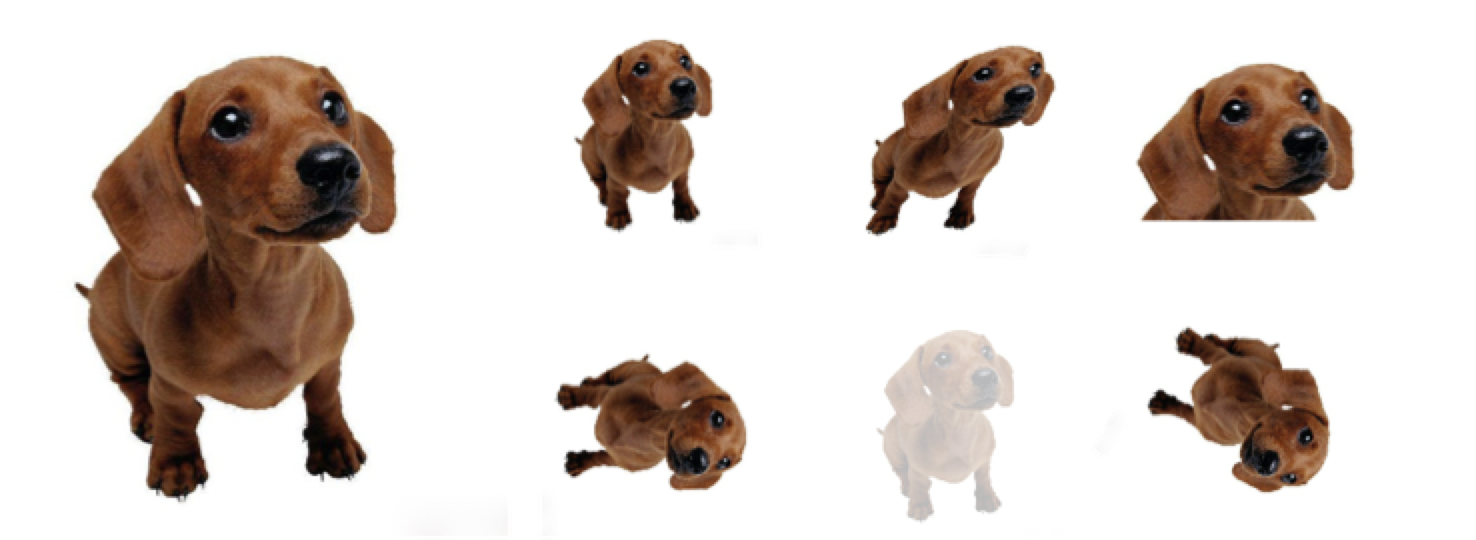

### 4.4.1 常用的数据增强方法
常见的数据增强方法可以分为几何空间变换方法以及像素颜色变换方法两大类。几何空间变换包括对图像进行翻转、剪切、缩放等，像素颜色变换包括增加噪声、进行颜色扰动、锐化、浮雕、模糊等。
    在TensorFlow中，我们可以结合使用数据增强方法与数据流水线，通常有以下两种方式：  
1）利用TensorFlow的预处理方法定义数据增强函数然后通过Sequential类加以应用；  
2）利用tf.image的内置方法手动创建数据增强路由。   
相比较而言，第一种方式更加简单，第二种方式相对复杂，但是更加灵活。接下来，我们以第二种方式为例进行演示，顺便探索tf.image为我们提供了哪些便利的函数。我们可以通过dir(tf.image)查看它的内置方法。
之前我们提到，图像的左右翻转可以使用tf.image.flip_left_right或者tf.image.random_flip_left_right来实现，而图像的上下翻转可以使用tf.image.flip_up_down或者tf.image.random_flip_up_down实现。更多的图像转换方法，可以查阅API文档。  
   下面我们用一个完整的例子来演示如何在Tensorflow流水线中配合使用tf.image来进行数据增强。首先我们定义一个函数来读取图像数据。  
1）定义导入数据函数。

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

def load_images(imagePath):
    # 从传入的路径中读取图片，并且转换数据成浮点数类型
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, (156, 156))
    
    # 获得图片名称作为标签
    label = tf.strings.split(imagePath, ".")[-2]
    
    # 返回图片数据以及标签
    return (image, label)

2）可视化数据增强效果。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


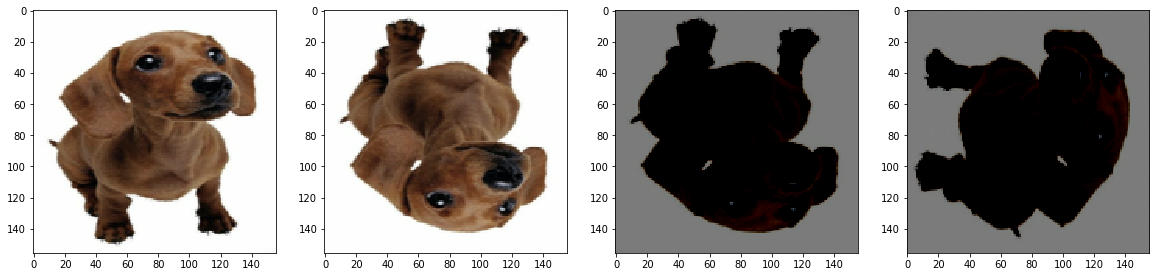

In [2]:
# 对图片进行上下左右随机的翻转以及调整明亮度,最后旋转图片。

imagePath = "./data/dog.jpg"
images,labels=load_images(imagePath)

fig = plt.gcf()
fig.set_size_inches(20, 30)    
images = tf.image.random_flip_left_right(images)
ax_raw1 = plt.subplot(1, 4, 1)
ax_raw1.imshow(images)
images = tf.image.random_flip_up_down(images)
ax_raw2 = plt.subplot(1, 4, 2)
ax_raw2.imshow(images)
images = tf.image.random_brightness(images, 1)
ax_raw3 = plt.subplot(1, 4, 3)
ax_raw3.imshow(images)
images = tf.image.rot90(images, 1)
ax_raw3 = plt.subplot(1, 4, 4)
ax_raw3.imshow(images)   


<center>图4-7 通过数据增强方法得到不同位置的图像</center>  
3）定义数据增强函数。   

In [3]:
def augment_using_ops(images, labels):
    # 对图片进行上下左右随机的翻转,调整明亮度最后旋转90度
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.random_brightness(images, 1)
    images = tf.image.rot90(images, 1)
    
    # 返回图片和标签
    return (images, labels)

### 4.4.2 创建数据处理流水线
把数据应用于深度学习模型训练时，数据本身往往需要各种预处理以满足模型输入参数的需要，tf.data提供了一系列有用的API来帮我们进行数据转换，比较常用的数据转换方法有：
 - map： 将（自定义或者TensorFlow定义）转换函数应用到数据集的每一个元素。
 - filter：选择数据集中符合条件的一系列元素。
 - shuffle： 对数据按照顺序打乱。
 - repeat： 将数据集中的数据重复N次，如果没有指定N，重复无限次。
 - take： 采样，取从开始起的N个元素。
 - batch： 构建批次，每次放一个批次。

In [4]:
BATCH_SIZE = 8
AUTOTUNE = tf.data.experimental.AUTOTUNE
# 输入图片的路径
imagePaths = ["./data/dog.jpg"]
# 创建数据输入流水线
ds = tf.data.Dataset.from_tensor_slices(imagePaths)

ds = ds.shuffle(len(imagePaths), seed=42).map(load_images,num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE)
ds = ds.map(augment_using_ops, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

#放到生成器里，单独取出数据
batch = next(iter(ds))

为了更加直观的显示出经过数据增强的效果，我们用matplotlib画出我们做过数据转换后的图片：

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data/dog


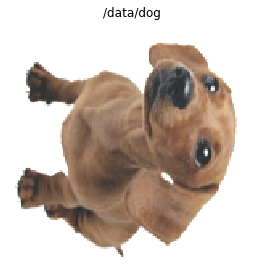

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
(image, label) = (batch[0][0], batch[1][0])
ax = plt.subplot()
plt.imshow(image.numpy())
print(label.numpy().decode("UTF-8"))
plt.title(label.numpy().decode("UTF-8"))
plt.axis("off")
plt.tight_layout()
plt.show()

<center>图4-8 经过处理后的图像</center>